In [1]:
%run notebook_setup.ipynb

In [2]:
%vault from pubmed_derived_data import literature, affiliations, authors, publication_types

Imported:

 - `literature` (6B6823C9)
 - `affiliations` (525C6ADE)
 - `authors` (90CEF5D4)
 - `publication_types` (50F4C1F9)

at Sunday, 12. Jul 2020 11:20

In [3]:
# ignore this line, it is just an overrite for my linters, to be removed in the final version-:
literature, affiliations, authors, publication_types = literature, affiliations, authors, publication_types

### Science Citation Index Expanded (SCIE)

Web of Science Core Collection, Last Updated: June 18, 2020, downloaded from https://mjl.clarivate.com/collection-list-downloads on 2020-06-23

In [4]:
from pandas import read_csv

web_of_science_journals = read_csv('data/wos-core_SCIE.csv')

In [5]:
web_of_science_journals

,Journal title,ISSN,eISSN,Publisher name,Publisher address,Languages,Web of Science Categories
0,2D MATERIALS,2053-1583,2053-1583,IOP PUBLISHING LTD,"TEMPLE CIRCUS, TEMPLE WAY, BRISTOL, ENGLAND, B...",English,"Materials Science, Multidisciplinary"
1,3 BIOTECH,2190-572X,2190-5738,SPRINGER HEIDELBERG,"TIERGARTENSTRASSE 17, HEIDELBERG, GERMANY, D-6...",English,Biotechnology & Applied Microbiology
2,3D PRINTING AND ADDITIVE MANUFACTURING,2329-7662,2329-7670,"MARY ANN LIEBERT, INC","140 HUGUENOT STREET, 3RD FL, NEW ROCHELLE, USA...",English,"Materials Science, Multidisciplinary | Enginee..."
3,4OR-A QUARTERLY JOURNAL OF OPERATIONS RESEARCH,1619-4500,1614-2411,SPRINGER HEIDELBERG,"TIERGARTENSTRASSE 17, HEIDELBERG, GERMANY, D-6...",English,Operations Research & Management Science
4,AAPG BULLETIN,0149-1423,1558-9153,AMER ASSOC PETROLEUM GEOLOGIST,"1444 S BOULDER AVE, PO BOX 979, TULSA, USA, OK...",English,"Geosciences, Multidisciplinary"
...,...,...,...,...,...,...,...
9388,ZOOSYSTEMA,1280-9551,1638-9387,"PUBLICATIONS SCIENTIFIQUES DU MUSEUM, PARIS","CP 39-57, RUE CUVIER, PARIS CEDEX 05, FRANCE, ...",English,Zoology
9389,ZOOSYSTEMATICS AND EVOLUTION,1860-0743,1860-0743,PENSOFT PUBLISHERS,"12 PROF GEORGI ZLATARSKI ST, SOFIA, BULGARIA, ...",English,Zoology
9390,ZOOTAXA,1175-5326,1175-5334,MAGNOLIA PRESS,"PO BOX 41383, AUCKLAND, NEW ZEALAND, ST LUKES,...",English,Zoology
9391,ZUCHTUNGSKUNDE,0044-5401,1867-4518,EUGEN ULMER GMBH CO,"POSTFACH 700561 WOLLGRASWEG 41, STUTTGART, GER...",German,"Agriculture, Dairy & Animal Science"


### SCImago Journal Rank

Downloaded from https://www.scimagojr.com/journalrank.php?out=xls on 2020-06-23

In [6]:
scimago = read_csv('data/scimagojr 2019.csv', sep=';')
scimago.head(10)

,Rank,Sourceid,Title,Type,Issn,SJR,SJR Best Quartile,H index,Total Docs. (2019),Total Docs. (3years),Total Refs.,Total Cites (3years),Citable Docs. (3years),Cites / Doc. (2years),Ref. / Doc.,Country,Region,Publisher,Coverage,Categories
0,1,28773,CA - A Cancer Journal for Clinicians,journal,"15424863, 00079235","88,192",Q1,156,36,129,2924,22644,89,"255,73","81,22",United States,Northern America,Wiley-Blackwell,1950-2020,Hematology (Q1); Oncology (Q1)
1,2,19434,MMWR. Recommendations and reports : Morbidity ...,journal,"10575987, 15458601","41,022",Q1,138,4,11,144,898,11,"52,00","36,00",United States,Northern America,Centers for Disease Control and Prevention (CDC),1990-2020,Epidemiology (Q1); Health Information Manageme...
2,3,21100812243,Nature Reviews Materials,journal,20588437,"36,691",Q1,80,85,288,8534,12569,151,"68,34","100,40",United Kingdom,Western Europe,Nature Publishing Group,2016-2020,"Biomaterials (Q1); Electronic, Optical and Mag..."
3,4,29431,Quarterly Journal of Economics,journal,"00335533, 15314650","36,220",Q1,246,30,123,1909,2020,119,"12,65","63,63",United Kingdom,Western Europe,Oxford University Press,1886-2020,Economics and Econometrics (Q1)
4,5,20315,Nature Reviews Molecular Cell Biology,journal,"14710072, 14710080","29,997",Q1,411,115,382,9251,8074,182,"47,70","80,44",United Kingdom,Western Europe,Nature Publishing Group,2000-2020,Cell Biology (Q1); Molecular Biology (Q1)
5,6,58530,National vital statistics reports : from the C...,book series,"15518922, 15518930","29,810",Q1,95,14,30,379,1059,30,"41,61","27,07",United States,Northern America,"Public Health Services, US Dept of Health and ...",1998-2020,Life-span and Life-course Studies (Q1)
6,7,18991,Nature Reviews Genetics,journal,"14710056, 14710064","28,619",Q1,345,113,376,8586,6416,154,"32,21","75,98",United Kingdom,Western Europe,Nature Publishing Group,2000-2020,Genetics (Q1); Genetics (clinical) (Q1); Molec...
7,8,18434,Cell,journal,"00928674, 10974172","24,698",Q1,747,581,1881,34924,49252,1630,"30,16","60,11",United States,Northern America,Cell Press,1974-2020,"Biochemistry, Genetics and Molecular Biology (..."
8,9,29719,Reviews of Modern Physics,journal,"00346861, 15390756","21,938",Q1,316,40,131,11080,5583,121,"45,73","277,00",United States,Northern America,American Physical Society,1929-2019,Physics and Astronomy (miscellaneous) (Q1)
9,10,12464,Nature Reviews Cancer,journal,"1474175X, 14741768","21,287",Q1,418,138,366,7641,8532,204,"37,77","55,37",United Kingdom,Western Europe,Nature Publishing Group,2001-2020,Cancer Research (Q1); Oncology (Q1)


In [7]:
scimago.Title.duplicated().any()

True

In [8]:
index_by_issn = {}
to_highlight = ['Title', 'Issn', 'SJR', 'H index', 'Country', 'Publisher']
for index, issns in scimago.Issn.str.split(', ').iteritems():
    for issn in issns:
        if issn == '-':
            continue
        if issn in index_by_issn:
            old_index = index_by_issn[issn]
            old = scimago.iloc[old_index][to_highlight].to_dict()
            new = scimago.iloc[index][to_highlight].to_dict()
            print(f'A publication with the same ISSN indexed twice:\n\t- {old}\n\t- {new}')
        index_by_issn[issn] = index

A publication with the same ISSN indexed twice:
	- {'Title': 'Proceedings - Annual IEEE Symposium on Foundations of Computer Science, FOCS', 'Issn': '02725428', 'SJR': '3,203', 'H index': 89, 'Country': 'France', 'Publisher': nan}
	- {'Title': 'Proceedings - Annual IEEE Symposium on Foundations of Computer Science, FOCS', 'Issn': '02725428', 'SJR': '2,444', 'H index': 81, 'Country': 'United States', 'Publisher': nan}
A publication with the same ISSN indexed twice:
	- {'Title': 'Neurosurgery', 'Issn': '15244040, 0148396X', 'SJR': '1,530', 'H index': 192, 'Country': 'United States', 'Publisher': 'Lippincott Williams and Wilkins Ltd.'}
	- {'Title': 'Clinical Neurosurgery', 'Issn': '0148396X, 00694827', 'SJR': '1,169', 'H index': 31, 'Country': 'United States', 'Publisher': 'Lippincott Williams and Wilkins Ltd.'}
A publication with the same ISSN indexed twice:
	- {'Title': 'Australian Journal of Psychology', 'Issn': '00049530, 17429536', 'SJR': '0,477', 'H index': 38, 'Country': 'United St

In [9]:
scimago_by_issn = scimago.set_index('Issn')

In [10]:
literature['journal_sjr_rank'] = literature['journal_issn'].str.replace('-', '').fillna('-').apply(lambda x: scimago.iloc[index_by_issn[x]].Rank if x in index_by_issn else None)#.dropna()

## A quick overview/hot-takes

cross-omics!

### Benchmarks

In [11]:
literature[literature.title.str.lower().str.contains('|'.join(['benchmark', 'evaluation', 'comparison']))][['title', 'journal', 'doi', 'journal_sjr_rank']].sort_values(['journal_sjr_rank', 'title'])

,title,journal,doi,journal_sjr_rank
uid,,,,
30295871,Multi-omic and multi-view clustering algorithm...,Nucleic acids research,10.1093/nar/gky889,90.0
30496480,Multi-omic and multi-view clustering algorithm...,Nucleic acids research,10.1093/nar/gky1226,90.0
22121217,The Stem Cell Discovery Engine: an integrated ...,Nucleic acids research,10.1093/nar/gkr1051,90.0
32234303,Multiomics Evaluation of Gastrointestinal and ...,Gastroenterology,10.1053/j.gastro.2020.03.045,169.0
31154149,"Quantitative CMR population imaging on 20,000 ...",Medical image analysis,10.1016/j.media.2019.05.006,409.0
30068331,Species comparison of liver proteomes reveals ...,BMC biology,10.1186/s12915-018-0547-y,447.0
32437529,Integrating multi-OMICS data through sparse Ca...,"Bioinformatics (Oxford, England)",10.1093/bioinformatics/btaa530,484.0
31792509,Clustering and variable selection evaluation o...,Briefings in bioinformatics,10.1093/bib/bbz138,625.0
29688321,Comparison and evaluation of integrative metho...,Briefings in bioinformatics,10.1093/bib/bby027,625.0


### Biomarkers

In [12]:
literature[literature.title.str.lower().str.contains('|'.join(['biomarker']))][['title', 'journal', 'doi', 'journal_sjr_rank']].sort_values(['journal_sjr_rank', 'title'])

,title,journal,doi,journal_sjr_rank
uid,,,,
31563876,Exploiting differential Wnt target gene expres...,Gut,10.1136/gutjnl-2019-319126,121.0
28838933,Epigenome-Wide Association Study Identifies Ca...,Circulation,10.1161/CIRCULATIONAHA.117.027355,142.0
24859455,Identification of prognostic biomarkers in hep...,Journal of hepatology,10.1016/j.jhep.2014.05.025,171.0
31501510,Multi-omic biomarker identification and valida...,Molecular psychiatry,10.1038/s41380-019-0496-z,187.0
31312043,Multi-omics in IBD biomarker discovery: the mi...,Nature reviews. Gastroenterology & hepatology,10.1038/s41575-019-0188-9,196.0
...,...,...,...,...
31731729,Interleukin-18 Is a Prognostic Biomarker Corre...,Journal of clinical medicine,10.3390/jcm8111993,NaN
29764059,Leveraging next-generation phenotyping and pan...,Personalized medicine,10.2217/pme.14.6,NaN
29781548,Multi-omics in high-grade serous ovarian cance...,American journal of reproductive immunology (N...,10.1111/aji.12975,NaN


In [13]:
literature[['title', 'journal', 'doi', 'journal_sjr_rank']].sort_values(['journal_sjr_rank', 'title']).head(20)

,title,journal,doi,journal_sjr_rank
uid,,,,
29479082,Integrative omics for health and disease.,Nature reviews. Genetics,10.1038/nrg.2018.4,7.0
31925408,Multi-omics shows the (default) way.,Nature reviews. Genetics,10.1038/s41576-020-0211-6,7.0
28970588,Technique: CRISPR CAPTURE for multi-omic probi...,Nature reviews. Genetics,10.1038/nrg.2017.79,7.0
31491384,Antibiotics-Driven Gut Microbiome Perturbation...,Cell,10.1016/j.cell.2019.08.010,8.0
29100071,Cancer Evolution during Immunotherapy.,Cell,10.1016/j.cell.2017.10.027,8.0
30595449,Gene Regulatory Programs Conferring Phenotypic...,Cell,10.1016/j.cell.2018.11.045,8.0
27863251,Genetic Drivers of Epigenetic and Transcriptio...,Cell,10.1016/j.cell.2016.10.026,8.0
31585088,Integrated Proteogenomic Characterization of H...,Cell,10.1016/j.cell.2019.08.052,8.0
32059783,Lymphoma Driver Mutations in the Pathogenic Ev...,Cell,10.1016/j.cell.2020.01.029,8.0


### Discoveries?

In [14]:
literature[literature.title.str.lower().str.contains('|'.join(['reveals']))][['title', 'journal', 'doi', 'journal_sjr_rank']].sort_values(['journal_sjr_rank', 'title']).head(20)

,title,journal,doi,journal_sjr_rank
uid,,,,
29328921,Tomato Multiomics Reveals Consequences of Crop...,Cell,10.1016/j.cell.2017.12.036,8.0
28285833,Integrative Proteomics and Phosphoproteomics P...,Immunity,10.1016/j.immuni.2017.02.010,50.0
29898900,Principled multi-omic analysis reveals gene re...,Genome research,10.1101/gr.227066.117,84.0
32182340,Multi-omic analysis of gametogenesis reveals a...,Nucleic acids research,10.1093/nar/gkaa163,90.0
31227589,Integrated multiomic analysis reveals comprehe...,Gut,10.1136/gutjnl-2019-318912,121.0
28544881,Mammalian Systems Biotechnology Reveals Global...,Cell systems,10.1016/j.cels.2017.04.009,131.0
26446169,A Cross-Species Analysis in Pancreatic Neuroen...,Cancer discovery,10.1158/2159-8290.CD-15-0068,137.0
29588317,Spatiotemporal Multi-Omics Mapping Generates a...,Circulation,10.1161/CIRCULATIONAHA.117.032291,142.0
27132591,Integrative Multi-omic Analysis of Human Plate...,American journal of human genetics,10.1016/j.ajhg.2016.03.007,143.0


### Affiliations

Most authors with given affiliation on papers:

In [15]:
affiliations.Affiliation.sorted_value_counts().head(5).to_frame()

,Affiliation
index,
"Department of Genetics, Stanford University School of Medicine, Stanford, CA, USA.",58
"Tohoku Medical Megabank Organization, Tohoku University, Sendai, Japan.",48
"College of Bioinformatics Science and Technology, Harbin Medical University, Harbin, China.",46
"The European Molecular Biology Laboratory, The European Bioinformatics Institute, The Wellcome Trust Genome Campus, Hinxton, Cambridgeshire CB10 1SD, UK.",39
"College of Bioinformatics Science and Technology, Harbin Medical University, Harbin, Heilongjiang 150086, China.",32


Most papers with given affiliation:

In [16]:
affiliations[['Affiliation', 'PMID']].drop_duplicates().Affiliation.sorted_value_counts().head(10).to_frame()

,Affiliation
index,
"College of Bioinformatics Science and Technology, Harbin Medical University, Harbin, China.",7
"Department of Genetics, Stanford University School of Medicine, Stanford, CA, USA.",7
"University of Chinese Academy of Sciences, Beijing 100049, China.",6
"Luxembourg Centre for Systems Biomedicine, University of Luxembourg, Esch-sur-Alzette, Luxembourg.",5
"Blavatnik School of Computer Science, Tel Aviv University, Tel Aviv, Israel.",4
"College of Bioinformatics Science and Technology, Harbin Medical University, Harbin, Heilongjiang 150086, China.",4
"Computer Laboratory, University of Cambridge Cambridge, UK.",4
"Department of Bioinformatics and Computational Biology, The University of Texas MD Anderson Cancer Center, Houston, TX 77030, USA.",4
"Department of Biology, Institute of Molecular Systems Biology, ETH Zurich, Zurich, Switzerland.",4


We were previously getting false hits because we were matching by affiliations:
 - "Multi-Omics Based Creative Drug Research Team, Kyungpook National University, Daegu 41566, Republic of Korea"
 - "Panomics, Inc"
 
so it is important to check if no affiliations overrepresented. Would need a cleanup to be more reliable (not a priority).

###  Authors

Note: not neccessarily unique persons, adoption of ORCID still low:

In [17]:
authors['JointName'].sorted_value_counts().head(15).to_frame()

,JointName
index,
Richard D Smith,19
Paul Wilmes,18
Jens Nielsen,17
Xia Li,16
Young-Mo Kim,16
Thomas O Metz,15
Bernhard O Palsson,13
James G Wilson,13
Li Wang,13


### Publication kind and type

In [18]:
literature.kind.sorted_value_counts()

index
article            3203
article in book       3
Name: kind, dtype: int64

In [19]:
sum(literature['Is Review'] == True)

696

In [20]:
publication_types['0'].sorted_value_counts().to_frame('count')

,count
index,
Journal Article,3126
"Research Support, Non-U.S. Gov't",1275
Review,696
"Research Support, N.I.H., Extramural",435
"Research Support, U.S. Gov't, Non-P.H.S.",152
Editorial,43
Comparative Study,36
Comment,35
Clinical Trial,26


In [21]:
literature[literature['Is English Abstract'] == True][['title', 'doi']]

,title,doi
uid,,
22490743,[Application of an integrated omics analysis f...,NaN
24292186,[Biomarker exploration and its clinical use].,NaN
25744640,"[Gut microbiota, host defense and immunity: an...",10.2177/jsci.37.403
26351165,[Identification of disease targets for precisi...,10.16288/j.yczz.15-061


In [22]:
literature[literature['Is Interview'] == True][['title', 'doi']]

,title,doi
uid,,
22424393,Q & A: the Snyderome.,10.1186/gb-2012-13-3-147
31429661,Interview with Prof. K. Yalçın Arga: A Pioneer...,10.1089/omi.2019.0131
31755849,Interview with Prof. Collet Dandara: A Pioneer...,10.1089/omi.2019.0174


In [23]:
literature[literature['Is Congress'] == True][['title', 'doi']]

,title,doi
uid,,
27164162,Emergence of Biomolecular Pathways to Define N...,10.1165/rcmb.2016-0141PS
29339647,Proceedings of the 11th Congress of the Intern...,10.1159/000485799
31394729,Novel Strategies for Cancer Treatment: Highlig...,10.3390/cancers11081125


In [24]:
literature[literature['Is News'] == True][['title', 'doi']]

,title,doi
uid,,
29301609,Integration of metabolomics and transcriptomic...,NaN
32475383,From Genome Sequencing to the Discovery of Pot...,NaN


In [25]:
literature[literature['Is Dataset'] == True][['title', 'doi']]

,title,doi
uid,,
25632108,CyanOmics: an integrated database of omics for...,10.1093/database/bau127
26130662,toxoMine: an integrated omics data warehouse f...,10.1093/database/bav066
26646939,Multi-omic profiles of human non-alcoholic fat...,10.1038/sdata.2015.68
27504011,MODEM: multi-omics data envelopment and mining...,10.1093/database/baw117
29087370,Monitoring microbial responses to ocean deoxyg...,10.1038/sdata.2017.158
30084846,A multi-omic atlas of the human frontal cortex...,10.1038/sdata.2018.142
30204156,"The Mount Sinai cohort of large-scale genomic,...",10.1038/sdata.2018.185
30621600,The 1000IBD project: multi-omics data of 1000 ...,10.1186/s12876-018-0917-5
31201317,Multi omics analysis of fibrotic kidneys in tw...,10.1038/s41597-019-0095-5


### Journals

In [26]:
journal_freq = literature.journal.sorted_value_counts()

In [27]:
journal_freq.head(20).to_frame()

,journal
index,
Scientific reports,123
Omics : a journal of integrative biology,76
PloS one,65
"Bioinformatics (Oxford, England)",61
Nature communications,54
Frontiers in genetics,53
Journal of proteomics,53
BMC bioinformatics,50
Nucleic acids research,45


Sanity check (is any of the top names not unique?) - the numbers should be same if countign by ISSN:

In [28]:
literature.journal_issn.sorted_value_counts().head(10)

index
2045-2322    123
1557-8100     75
1932-6203     65
1367-4811     61
2041-1723     54
1664-8021     53
1876-7737     53
1471-2105     50
1362-4962     45
1940-6029     41
Name: journal_issn, dtype: int64

In [29]:
journal_freq[journal_freq < 50]

index
Nucleic acids research                                                     45
Methods in molecular biology (Clifton, N.J.)                               42
Journal of proteome research                                               41
BMC genomics                                                               37
Oncotarget                                                                 37
                                                                           ..
Zhongguo yi xue ke xue yuan xue bao. Acta Academiae Medicinae Sinicae       1
Zhonghua nan ke xue = National journal of andrology                         1
Zhonghua yu fang yi xue za zhi [Chinese journal of preventive medicine]     1
Zoology (Jena, Germany)                                                     1
mSphere                                                                     1
Name: journal, Length: 925, dtype: int64

In [30]:
literature['top_journals'] = literature.journal.copy()
literature.loc[literature.journal.isin(journal_freq[journal_freq < 50].index), 'top_journals'] = 'Other'

In [31]:
assert not literature.doi.dropna().duplicated().any()

In [32]:
from pandas import Series, to_datetime

In [33]:
literature['is_descriptive'] = literature['Is ' + Series(['Review', 'Editorial', 'Comment', 'Letter'])].any(axis=1)

In [34]:
from search_terms import primary_terms, secondary_terms, descriptive_terms
terms = [*primary_terms, *secondary_terms, *descriptive_terms]

In [35]:
literature = literature.replace({float('nan'): None}).infer_objects()
literature.date = to_datetime(literature.date)
%R -i literature -i terms

In [36]:
%%R
library(ComplexUpset)
source('helpers/plots.R')
source('helpers/colors.R')

In [37]:
publication_types_list = ['Is ' + t for t in publication_types['0'].sorted_value_counts().where(lambda x: x > 10).dropna().index]

R[write to console]: Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



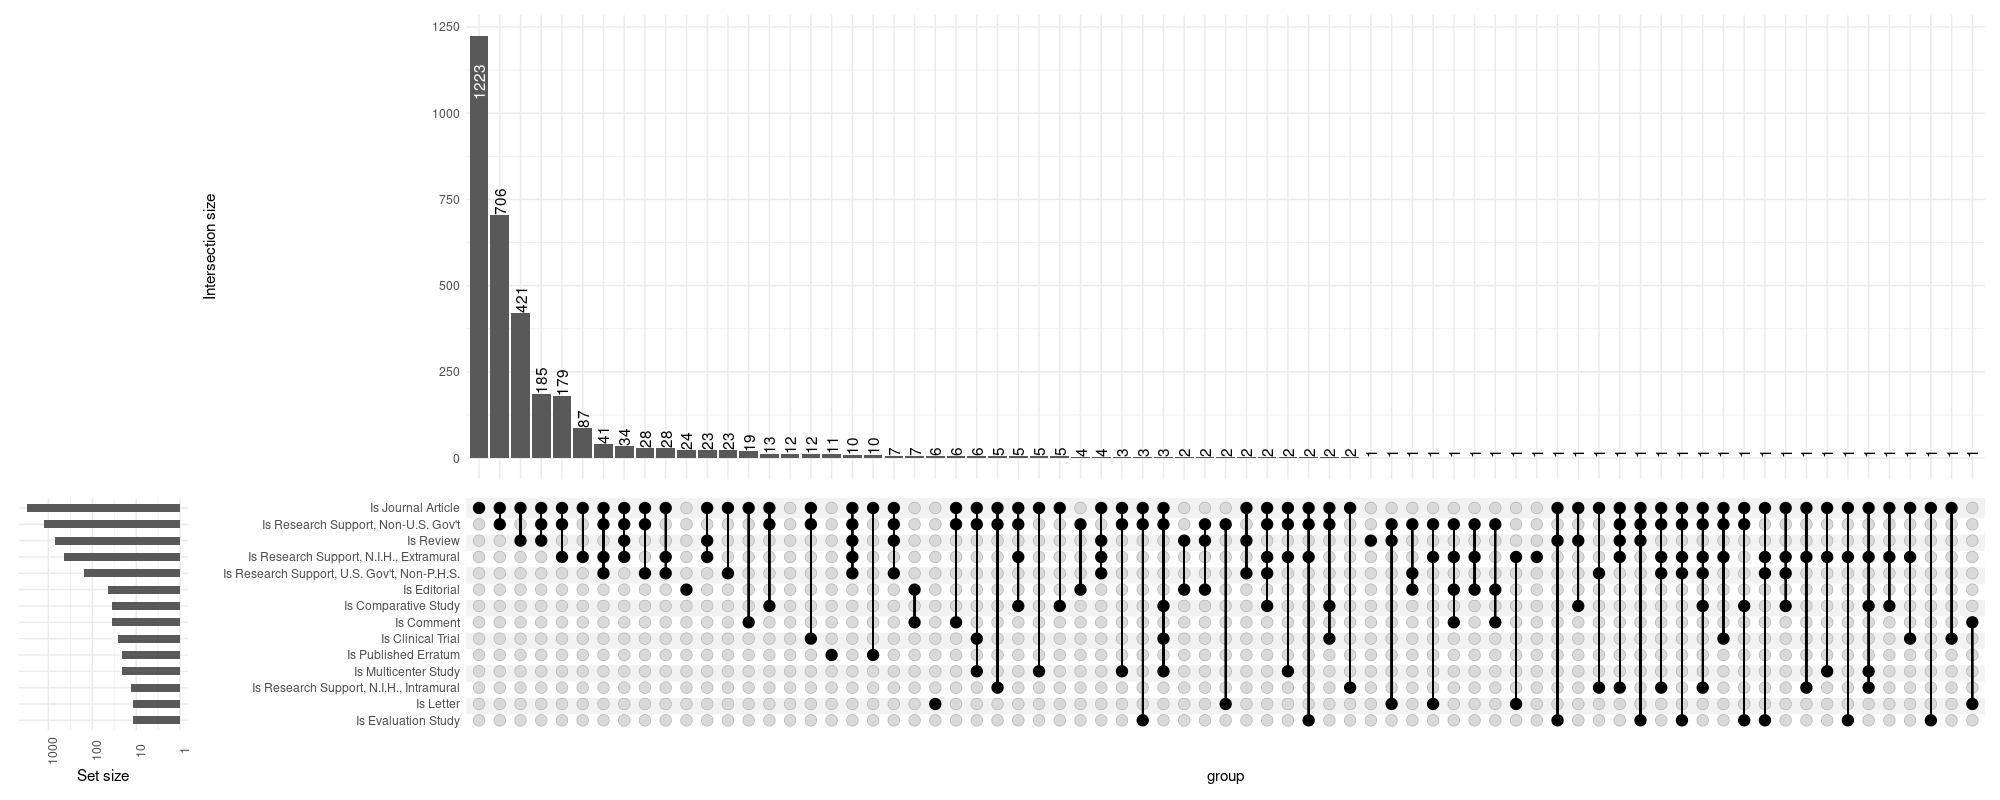

In [38]:
%%R -i publication_types_list -w 2000 -r 100 -h 800

upset(
    literature,
    publication_types_list,
    base_annotations=list(
        'Intersection size'=intersection_size(
            text=list(angle=90, vjust=0.5, hjust=0)
        )
    ),
    width_ratio=0.1,
    set_sizes=upset_set_size(
        width=0.5,
        layers=list(
            scale_y_continuous(trans=reverse_log_trans())
        )
    ),
    themes=upset_modify_themes(
        list('overall_sizes'=theme(axis.text.x=element_text(angle=90)))
    )
)

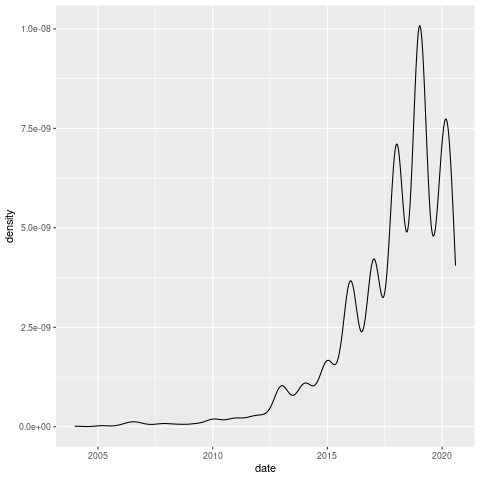

In [39]:
%%R
ggplot(literature, aes(x=date)) + geom_density()

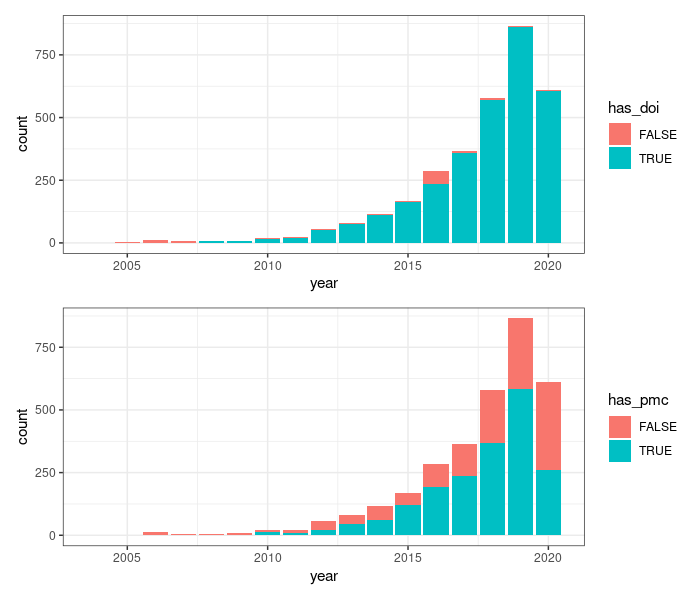

In [40]:
%%R -w 700 -h 600 -r 100
(
    ggplot(literature, aes(x=year, fill=has_doi))
    + geom_bar()
    + theme_bw()
) + (
    ggplot(literature, aes(x=year, fill=has_pmc))
    + geom_bar()
    + theme_bw()
) & plot_layout(ncol=1)

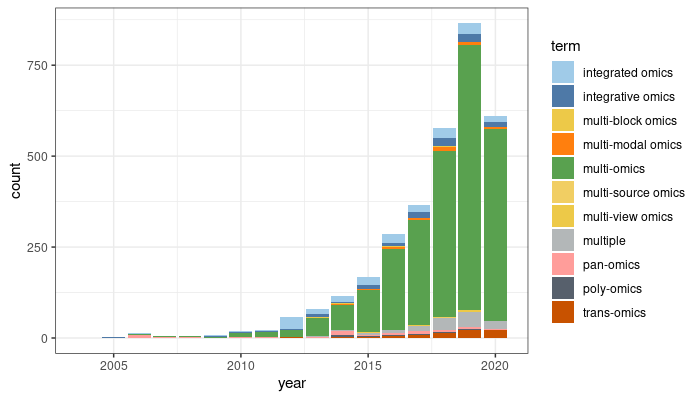

In [41]:
%%R -w 700 -h 400 -r 100
(
    ggplot(literature, aes(x=year, fill=term))
    + geom_bar()
    + scale_fill_manual(values=terms_colors)
    + theme_bw()
)

### A venn diagram showing the overlap of papers using multi-omics/pan-omics etc.

R[write to console]: Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



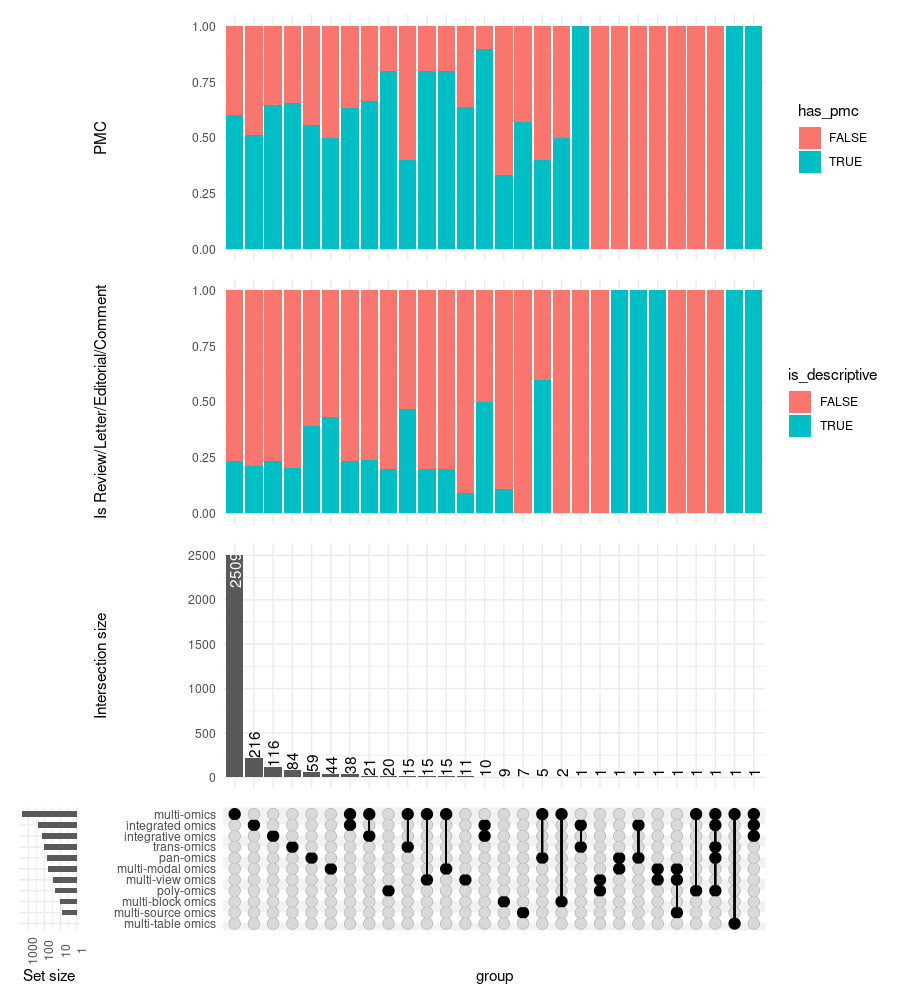

In [42]:
%%R -w 900 -r 100 -h 1000

upset(
    literature,
    terms,
    base_annotations=list(
        'Intersection size'=intersection_size(
            text=list(angle=90, vjust=0.5, hjust=0)
        )
    ),
    annotations=list(
        # could do some journal statistic (impact factor?)
        #'Journal'=list(
        #    aes=aes(x=intersection, fill=top_journals),
        #    geom=list(
        #        geom_bar(stat='count', position='fill'),
        #        scale_fill_discrete()
        #    )
        #),
        'PMC'=list(
            aes=aes(x=intersection, fill=has_pmc),
            geom=list(
                geom_bar(stat='count', position='fill'),
                scale_fill_discrete()
            )
        ),
        'Is Review/Letter/Editorial/Comment'=list(
            aes=aes(x=intersection, fill=is_descriptive),
            geom=list(
                geom_bar(stat='count', position='fill'),
                scale_fill_discrete()
            )
        )
    ),
    width_ratio=0.1,
    set_sizes=upset_set_size(
        width=0.5,
        layers=list(
            scale_y_continuous(trans=reverse_log_trans())
        )
    ),
    themes=upset_modify_themes(
        list('overall_sizes'=theme(axis.text.x=element_text(angle=90)))
    )
)

In [43]:
literature[literature[list(terms)].sum(axis=1) > 2][['title', 'doi', 'abstract_clean']]

,title,doi,abstract_clean
uid,,,
28624903,Early Diagnosis of Sepsis: Is an Integrated Om...,10.1007/s40291-017-0282-z,Sepsis remains one of the leading causes of de...
30006342,"Integrated Omics: Tools, Advances, and Future ...",10.1530/JME-18-0055,With the rapid adoption of high-throughput omi...
32186712,Adaptive multi-source multi-view latent featur...,10.1093/bib/bbaa028,Accumulating evidence has shown that microRNAs...


**new search term - multi source!**